In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import warnings; warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from scipy import stats
from numpy import mean
from numpy import std
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV, Ridge, lars_path
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from catboost import CatBoostRegressor

from sklearn.datasets import make_classification, make_regression
from sklearn.feature_selection import RFE



Final Lasso prediction for cylinders is: -0.5167
Final Lasso prediction for displacement is: -1.0778
Final Lasso prediction for horsepower is: -0.4458
Final Lasso prediction for weight is: -3.1328
Final Lasso prediction for acceleration is: -0.4318
Final Lasso prediction for year is: 0.5300
Final Lasso prediction for origin is: 0.8242
.

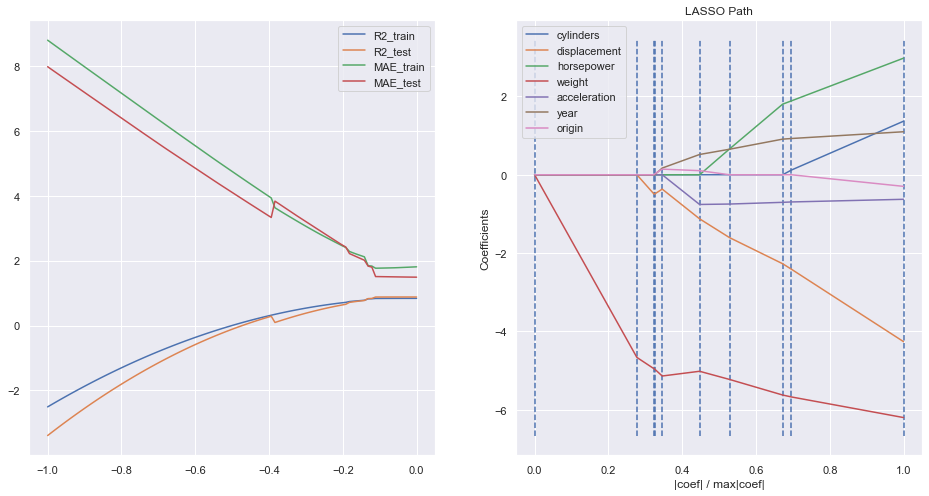

In [122]:
#######################
# 0. Load and Standardize X Data 
df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/Auto.csv")
df = df.iloc[0:200]
df = df.drop(['name'], axis=1)
df['origin'] = pd.Categorical(df['origin'])
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df=df.dropna(how="any")
dfs = df.astype('int')
x = dfs.drop(['mpg'], axis=1)
X= StandardScaler().fit_transform(x)
y = dfs['mpg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
#######################
# 1. Define alpha range; train Lasso models with alphas
alphas = np.linspace(-1,0, 100)
MAE_tr, MAE_te, r2_tr, r2_te=[], [], [], []
for a in alphas:
    lasso=Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    y_train_pred=lasso.predict(X_train)
    y_test_pred=lasso.predict(X_test)
    MAE_train=metrics.mean_absolute_error(y_train, y_train_pred)
    MAE_test=metrics.mean_absolute_error(y_test, y_test_pred)
    MAE_tr.append(MAE_train)
    MAE_te.append(MAE_test)
    r2_train=lasso.score(X_train, y_train)
    r2_test=lasso.score(X_test, y_test)
    r2_tr.append(r2_train)
    r2_te.append(r2_test)
#######################
# 2. Choose "best" Lasso (min R2, max MAE) 
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(alphas, r2_tr, label='R2_train')
plt.plot(alphas, r2_te, label='R2_test')
plt.plot(alphas, MAE_tr, label='MAE_train')
plt.plot(alphas, MAE_te, label='MAE_test')
plt.legend()

df_alpha=pd.DataFrame()
df_alpha['alpha']=alphas
df_alpha['R2_test']=r2_te
df_alpha['R2_train']=r2_tr
df_alpha['MAE_train']=MAE_tr
df_alpha['MAE_test']=MAE_te
for i, j in enumerate(df_alpha['R2_test']):
    if j==df_alpha['R2_test'].max():
        best_alpha=df_alpha['alpha'][i]
#######################
# 3. Fit the best Lasso model  
final_lasso=Lasso(alpha=best_alpha) 
final_lasso.fit(X_train, y_train)
for col, coef in zip(x.columns, final_lasso.coef_):
    print(('Final Lasso prediction for '+ str(col)+ ' is: %.4f') %coef)
    
#######################
# 4. Feature Importance via Lars Path      
_, _, coefs = lars_path(X_train, y_train, method='lasso', verbose=True)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]
plt.subplot(1,2,2)
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(x.columns)
plt.show()

In [30]:
from sklearn.linear_model import Lasso
reg = Lasso(alpha=0.5)
reg.fit(X_train, y_train)

print('Lasso Regression: R^2 score on training set', reg.score(X_train, y_train)*100)
print('Lasso Regression: R^2 score on test set', reg.score(X_test, y_test)*100)

Lasso Regression: R^2 score on training set 82.65578691296899
Lasso Regression: R^2 score on test set 84.83681965454008


In [15]:
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

In [16]:
# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

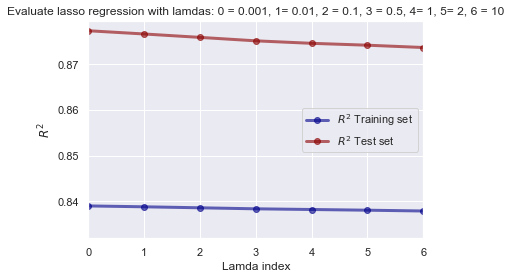

In [40]:
# Plotting

plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')


In [18]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    88.103815
lambda        0.001000
Name: 0, dtype: float64

In [19]:
# Coefficients of best model
reg_best = Lasso(alpha = 0.1)
reg_best.fit(X_train, y_train)
reg_best.coef_

array([-0.00000000e+00, -1.55437200e-02,  2.41817387e-04, -3.58524064e-03,
       -5.69741011e-02,  2.23635403e-01,  7.48256518e-01])

In [20]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, reg_best.predict(X_test))

3.6932199479805115

In [91]:
l_min = 0.05
l_max = 0.2
l_num = 20
lambdas = np.linspace(l_min,l_max, l_num)

train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

pred_num = X.shape[1]
coeff_a = np.zeros((l_num, pred_num))

In [107]:
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=5, scoring='neg_mean_absolute_error')

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

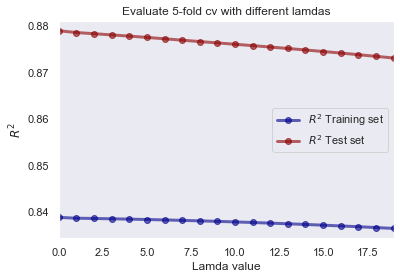

In [109]:
# Plotting

plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda value'); plt.ylabel(r'$R^2$')
plt.xlim(0, 19)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

In [101]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    87.897525
lambda        0.050000
Name: 0, dtype: float64

In [102]:
# Best Model
reg_best = Lasso(alpha = 0.144737)
reg_best.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, reg_best.predict(X_test))
reg_best.coef_

array([-0.34136411, -1.18223273, -0.        , -3.27132984,  0.        ,
        0.33262331,  0.71385488])